<a href="https://colab.research.google.com/github/Meshva-p/Credit-risk-modelling-PySpark-/blob/main/Pyspark_credit_risk_cleaned_analysis%2Bpipe%2Bmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip "/content/drive/My Drive/Big Data/me/german_cerdit.csv"

Archive:  /content/drive/My Drive/Big Data/me/SouthGermanCredit.zip
   creating: SouthGermanCredit/
  inflating: SouthGermanCredit/test.csv  
  inflating: SouthGermanCredit/train.csv  


# **Installing PySpark**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.1.2-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"


In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.1.2-bin-hadoop3.2'

In [ ]:
findspark.find()

'/content/spark-3.1.2-bin-hadoop3.2'

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')

--2021-11-04 17:02:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 52.202.168.65, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  3.26MB/s    in 5.1s    

2021-11-04 17:02:44 (2.60 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[{"name":"command_line","uri":"/api/tunnels/command_line","public_url":"https://5bac-35-197-105-211.ngrok.io","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}},{"name":"command_line (http)","uri":"/api/tunnels/command_line%20%28http%29","public_url":"http://5bac-35-197-105-211.ngrok.io","proto":"http","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}}],"uri":"/api/tunnels"}


In [ ]:
# for checking the SparkUI 
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://5bac-35-197-105-211.ngrok.io


# **Risk** **Modelling Cleaning dataset**

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# maybe unneccessary packages - TEST
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pyspark

In [ ]:
df = spark.read.csv("/content/drive/My Drive/Big Data/me/cr_default.csv", header=True, inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- person_age: integer (nullable = true)
 |-- person_income: integer (nullable = true)
 |-- person_home_ownership: string (nullable = true)
 |-- person_emp_length: integer (nullable = true)
 |-- loan_intent: string (nullable = true)
 |-- loan_grade: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- loan_int_rate: double (nullable = true)
 |-- loan_status: integer (nullable = true)
 |-- loan_percent_income: double (nullable = true)
 |-- cb_person_default_on_file: string (nullable = true)
 |-- cb_person_cred_hist_length: integer (nullable = true)



In [ ]:
df.show(5)

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|        22|        59000|                 RENT|              123|   PERSONAL|         D|    35000|        16.02|          1|               0.59|                        Y|                         3|
|        21|         9600|                  OWN|                5|  EDUCATION|         B|     1000|        11.14|          0|                0.1|                        N|                         2|
|    

In [ ]:
df.count()

32581

In [ ]:
df.describe().show()

+-------+-----------------+-----------------+---------------------+-----------------+-----------------+----------+-----------------+------------------+-------------------+-------------------+-------------------------+--------------------------+
|summary|       person_age|    person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|        loan_amnt|     loan_int_rate|        loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+-------+-----------------+-----------------+---------------------+-----------------+-----------------+----------+-----------------+------------------+-------------------+-------------------+-------------------------+--------------------------+
|  count|            32581|            32581|                32581|            31686|            32581|     32581|            32581|             29465|              32581|              32581|                    32581|                     32581|
|   mean|27.73459992

In [ ]:
df.columns

['person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

In [ ]:

# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
x=df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|         0|            0|                    0|              895|          0|         0|        0|         3116|          0|                  0|                        0|                         0|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



 **Impute** : 
*   **the person_emp_length => take the median of it**
*   **loan_int_rate => take mean of it**


In [ ]:
# changed person_emp_length to median
#df1 = df.fillna(value=2, subset=['person_emp_length']).show(150)

In [ ]:
import pyspark.sql.functions as func 

#mean for  = 4.78
#df.agg({'person_emp_length': 'mean'}).show()

#mode for person_emp_length ; 0
#df.groupby("person_emp_length").count().orderBy("count", ascending=False).first()[0]

#median for person_emp_length ; 2
df.approxQuantile("person_emp_length", [0.5], 0.25)

[2.0]

In [ ]:
#median for loan_int_rate
#df.approxQuantile("loan_int_rate", [0.5], 0.25)

#taking mean instead
df.agg({'loan_int_rate': 'mean'}).show()

+------------------+
|avg(loan_int_rate)|
+------------------+
| 11.01169489224439|
+------------------+



In [ ]:
'''from pyspark.ml.feature import Imputer
imputer = Imputer()
imputer.setInputCols(["person_emp_length"])
imputer.setOutputCols(["person_emp_length_new"])
imputer.setStrategy("median")
model = imputer.fit(df)
model.transform(df).show(150)
model.surrogateDF.show()
'''

In [ ]:
df1 = df.na.fill(value=2, subset=['person_emp_length'])
df1.show(150)

In [ ]:
df2 = df1.fillna(value=11.01, subset=['loan_int_rate'])
df2.show(150)

In [ ]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
x=df2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|         0|            0|                    0|                0|          0|         0|        0|            0|          0|                  0|                        0|                         0|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



 **Outlier Detection** 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


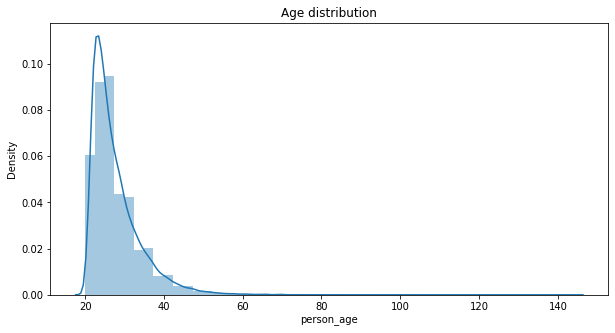

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = df2.toPandas()

plt.figure(figsize=(10,5))
plt.title('Age distribution')
sns.distplot(pandas_df['person_age']);

In [ ]:
cols = ["person_age" , "person_emp_length"]
bounds = {}

for c in cols:
  quantiles = df2.approxQuantile(c, [0.05,0.95], 0.01)
  IQR = quantiles[1] - quantiles[0]
  bounds[c] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]


In [ ]:
bounds

{'person_age': [-3.5, 64.5], 'person_emp_length': [-18.0, 30.0]}

In [ ]:
outliers = df2.select(df2.columns + 
                     [((df2[c] < bounds[c][0]) | (df2[c] > bounds[c][1])).alias(c+ "_outliers") for c in cols])
outliers.show(10)

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|person_age_outliers|person_emp_length_outliers|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-------------------+--------------------------+
|        22|        59000|                 RENT|              123|   PERSONAL|         D|    35000|        16.02|          1|               0.59|                        Y|                         3|              false|                      true|
|        21|    

In [ ]:
outliers.groupby('person_age_outliers').count().toPandas()

,person_age_outliers,count
0,True,44
1,False,32537


In [ ]:
outliers.groupby('person_emp_length_outliers').count().toPandas()

,person_emp_length_outliers,count
0,True,9
1,False,32572


In [ ]:
filtered_cols = outliers.filter(outliers["person_age_outliers"] == False)
final_filtered_cols = filtered_cols.filter(filtered_cols["person_emp_length_outliers"] == False)

In [ ]:
final_filtered_cols.show()

In [ ]:
final_filtered_cols.count()

32529

dropping the outlier columns for final clean data

In [ ]:
x = final_filtered_cols.drop('person_age_outliers')

In [ ]:
x.show()

In [ ]:
y = x.drop('person_emp_length_outliers')

In [ ]:
y.show()

In [ ]:
y.count()

32529

In [ ]:
y.write.csv("/content/drive/My Drive/Big Data/me/cleaned_credit_risk_data")

# **Preliminary Analysis**

In [ ]:
y.agg({"loan_amnt" : "skewness"}).show()
# o/p shows loan_amnt kind of highly skewed - asymmetrically

+-------------------+
|skewness(loan_amnt)|
+-------------------+
|  1.190732789564805|
+-------------------+



In [ ]:
y.agg({"loan_amnt" : "kurtosis"}).show()

+-------------------+
|kurtosis(loan_amnt)|
+-------------------+
| 1.4177913004313893|
+-------------------+



In [ ]:
!pip install bokeh

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import bokeh as b
from bokeh.io import output_notebook
output_notebook()

In [ ]:
hist = y.select('loan_amnt').rdd.flatMap(lambda row: row).histogram(20)

Text(0.5, 1.0, "Histogram of 'loan_amnt'")

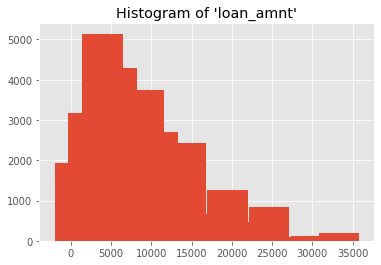

In [ ]:
data = {
 'bins': hist[0][:-1],
 'freq': hist[1]
}
plt.bar(data['bins'], data['freq'], width=5000)
plt.title('Histogram of \'loan_amnt\'')


In [ ]:
from bokeh.plotting import *
from bokeh.models import ColumnDataSource, Grid, LinearAxis, Plot, Scatter
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row 
from bokeh.plotting import figure
output_notebook()
numerical = ['person_age', 'person_emp_length', 'person_income', 'loan_amnt','loan_int_rate', 'loan_percent_income','cb_person_cred_hist_length']

data_multi = dict([
 (elem, y.select(elem).rdd \
 .flatMap(lambda row: row).collect()) 
 for elem in numerical
])

p = figure(title = "person_age x person_emp_length")
p.circle('person_age','person_emp_length',source=data_multi,fill_alpha=0.2, size=5)
p.xaxis.axis_label = 'person_age'
p.yaxis.axis_label = 'person_emp_length'
show(p)

In [ ]:
## only numerical columns positive correlations

numeric_cols = ["person_age", "loan_status",'person_emp_length', 'person_income', 'loan_amnt','loan_int_rate', 'loan_percent_income','cb_person_cred_hist_length']
numeric_rdd = y\
 .select(numeric_cols)\
 .rdd \
 .map(lambda row: [e for e in row])

In [ ]:
import pandas as pd
from pyspark.mllib.stat import Statistics

corrs = Statistics.corr(numeric_rdd)
for i, el in enumerate(corrs > 0.1):
 correlated = [
 (numeric_cols[j], corrs[i][j]) 
 for j, e in enumerate(el) 
 if e == 1.0 and j != i]
 if len(correlated) > 0:
  for e in correlated:
    print('{0}-         to         -{1}:                {2:.2f}'.format(numeric_cols[i], e[0], e[1]))


person_age-         to         -person_emp_length:                0.17
person_age-         to         -person_income:                0.14
person_age-         to         -cb_person_cred_hist_length:                0.88
loan_status-         to         -loan_amnt:                0.10
loan_status-         to         -loan_int_rate:                0.32
loan_status-         to         -loan_percent_income:                0.38
person_emp_length-         to         -person_age:                0.17
person_emp_length-         to         -person_income:                0.16
person_emp_length-         to         -loan_amnt:                0.12
person_emp_length-         to         -cb_person_cred_hist_length:                0.15
person_income-         to         -person_age:                0.14
person_income-         to         -person_emp_length:                0.16
person_income-         to         -loan_amnt:                0.32
person_income-         to         -cb_person_cred_hist_length:     

In [ ]:
y.groupBy('person_home_ownership').count().show()

+---------------------+-----+
|person_home_ownership|count|
+---------------------+-----+
|                  OWN| 2583|
|                 RENT|16414|
|             MORTGAGE|13425|
|                OTHER|  107|
+---------------------+-----+



In [ ]:
y.groupBy('loan_intent').count().show()

+-----------------+-----+
|      loan_intent|count|
+-----------------+-----+
|DEBTCONSOLIDATION| 5209|
|          VENTURE| 5713|
|         PERSONAL| 5507|
|        EDUCATION| 6447|
|  HOMEIMPROVEMENT| 3603|
|          MEDICAL| 6050|
+-----------------+-----+



In [ ]:
y.groupBy('loan_grade').count().show()

+----------+-----+
|loan_grade|count|
+----------+-----+
|         F|  241|
|         E|  961|
|         B|10434|
|         D| 3617|
|         C| 6448|
|         A|10764|
|         G|   64|
+----------+-----+





# **Big Data pipeline** and train test split



In [ ]:
splits = y.randomSplit([0.80, 0.20])
train_data = splits[0]
test_data = splits[1]


*   use string indexer for "person_home_ownership", "loan_intent" , "loan_grade" , "cb_person_default_on_file"
*   use vector assembler for numerical columns and min max scaling  
*   fit the outputcol to pipeline for train and test





In [ ]:
from pyspark.ml.feature import StringIndexer

person_home_ownership_indexer = StringIndexer(inputCol="person_home_ownership", outputCol="person_home_ownership_Index")
loan_intent_indexer = StringIndexer(inputCol="loan_intent", outputCol="loan_intent_Index")
loan_grade_indexer = StringIndexer(inputCol="loan_grade", outputCol="loan_grade_Index")
cb_person_default_on_file_indexer = StringIndexer(inputCol="cb_person_default_on_file", outputCol="cb_person_default_on_file_Index")


In [ ]:
'''categorical_features = ["person_home_ownership","loan_intent","loan_grade","cb_person_default_on_file"]
catVect = VectorAssembler(inputCols = categorical_features, outputCol = "catFeatures")
catIdx = VectorIndexer(inputCol = catVect.getOutputCol(), outputCol = "idxCatFeatures")
'''

In [ ]:
numerical_features = ["person_age",'person_emp_length', 'person_income', 'loan_amnt','loan_int_rate', 'loan_percent_income','cb_person_cred_hist_length']
numVect = VectorAssembler(inputCols = numerical_features, outputCol = "numFeatures")
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol = "normFeatures")

In [ ]:
# Define pipeline 
featVect = VectorAssembler(inputCols=["person_home_ownership_Index","loan_intent_Index","loan_grade_Index","cb_person_default_on_file_Index","normFeatures"], outputCol = "features")
pipeline = Pipeline(stages = [person_home_ownership_indexer,loan_intent_indexer,loan_grade_indexer,cb_person_default_on_file_indexer,numVect, minMax, featVect])
pipeline_object = pipeline.fit(train_data)

In [ ]:
# Run training and test data through the pipeline
train_data = pipeline_object.transform(train_data).select("features", col("loan_status").alias("label"))
test_data = pipeline_object.transform(test_data).select("features", col("loan_status").alias("label"))

In [ ]:
print(train_data.show(5))
print("Number of observations in training / test data:", train_data.count(), "/", test_data.count())

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,3.0,3.0,0.0,...|    1|
|[0.0,2.0,3.0,1.0,...|    1|
|[1.0,0.0,1.0,0.0,...|    0|
|[1.0,0.0,1.0,0.0,...|    0|
|[1.0,4.0,0.0,0.0,...|    0|
+--------------------+-----+
only showing top 5 rows

None
Number of observations in training / test data: 26043 / 6486


In [ ]:
test_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,1.0,2.0,1.0,...|    0|
|[0.0,2.0,1.0,0.0,...|    0|
|[1.0,2.0,1.0,0.0,...|    0|
|[1.0,2.0,0.0,0.0,...|    0|
|[0.0,2.0,2.0,0.0,...|    1|
+--------------------+-----+
only showing top 5 rows



# **Model Training and Test**

In [ ]:
accuracy = MulticlassClassificationEvaluator(
    labelCol = "label", predictionCol = "prediction", metricName = "accuracy")
precision = MulticlassClassificationEvaluator(
    labelCol = "label", predictionCol = "prediction", metricName = "weightedPrecision")
recall = MulticlassClassificationEvaluator(
    labelCol = "label", predictionCol = "prediction", metricName = "weightedRecall")

**Logistic Regression**

In [ ]:
logit = LogisticRegression(labelCol = "label", featuresCol = "features", maxIter = 100, regParam = 0.01)
model = logit.fit(train_data)
predictions_df = model.transform(test_data)

print("Accuracy: {:.4}".format(accuracy.evaluate(predictions_df)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions_df)))
print("Weighted recall: {:.4}".format(recall.evaluate(predictions_df)))

Accuracy: 0.8524
Weighted precision: 0.8442
Weighted recall: 0.8524


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,RegressionEvaluator
from pyspark.mllib.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

evaluator = RegressionEvaluator(metricName="accuracy")
lr2 = LogisticRegression(labelCol = 'label', featuresCol = 'features')
grid = ParamGridBuilder().addGrid(lr2.regParam, [0.1, 0.01, 0.001, 0.0001]).build()
evaluator = BinaryClassificationEvaluator(labelCol = 'label')
cv = CrossValidator(estimator=lr2, estimatorParamMaps=grid, evaluator=evaluator)
cvModel = cv.fit(train_data)

In [ ]:
import numpy as np
cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ]

{Param(parent='LogisticRegression_ef209b9d95dc', name='regParam', doc='regularization parameter (>= 0).'): 0.001}

In [ ]:
cvModel.bestModel.coefficients

DenseVector([-0.8762, 0.1455, 0.8843, -0.1341, -0.0278, -0.272, 1.9553, -3.1134, -0.036, 9.8963, 0.0459])

In [ ]:
bestModel = cvModel.bestModel

print ('Best Param (regParam): ', bestModel._java_obj.getRegParam())

print ('Best Param (MaxIter): ', bestModel._java_obj.getMaxIter())

print ('Best Param (elasticNetParam): ', bestModel._java_obj.getElasticNetParam())

Best Param (regParam):  0.001
Best Param (MaxIter):  100
Best Param (elasticNetParam):  0.0


In [ ]:
logreg = LogisticRegression(labelCol = "label", featuresCol = "features", maxIter = 100, regParam = 0.001,elasticNetParam=0)
log_model = logreg.fit(train_data)
pred_df = log_model.transform(test_data)

print("Accuracy: {:.4}".format(accuracy.evaluate(pred_df)))
print("Weighted precision: {:.4}".format(precision.evaluate(pred_df)))
print("Weighted recall: {:.4}".format(recall.evaluate(pred_df)))

Accuracy: 0.8571
Weighted precision: 0.8492
Weighted recall: 0.8571


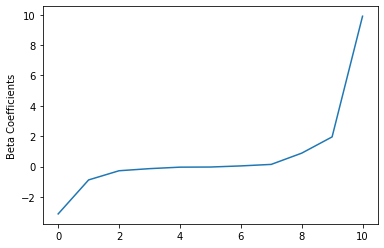

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(log_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

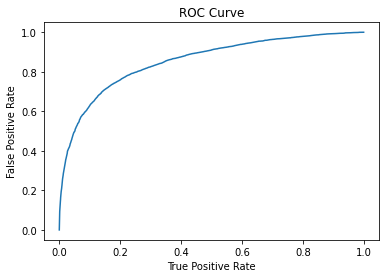

Training set areaUnderROC: 0.8539820648804427


In [ ]:
trainingSummary = log_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

**Decision Tree**

In [ ]:
tree = DecisionTreeClassifier(labelCol = "label", featuresCol = "features", maxDepth = 4, maxBins = 32, 
                              minInstancesPerNode = 1, minInfoGain = 0.0, impurity = "gini", seed = 123)
model_dt = tree.fit(train_data)
predt_df = model_dt.transform(test_data)

print("Accuracy: {:.4}".format(accuracy.evaluate(predt_df)))
print("Weighted precision: {:.4}".format(precision.evaluate(predt_df)))
print("Weighted recall: {:.4}".format(recall.evaluate(predt_df)))

Accuracy: 0.909
Weighted precision: 0.9065
Weighted recall: 0.909


**RandomForest Classifier**

In [ ]:
rf = RandomForestClassifier(labelCol = "label", featuresCol = "features", maxDepth = 4, maxBins = 32, 
                            minInstancesPerNode = 1, minInfoGain=0.0, impurity = "gini", numTrees = 10, seed = 123) 
model_rf = rf.fit(train_data)
predrf_df = model_rf.transform(test_data)

print("Accuracy: {:.4}".format(accuracy.evaluate(predrf_df)))
print("Weighted precision: {:.4}".format(precision.evaluate(predrf_df)))
print("Weighted recall: {:.4}".format(recall.evaluate(predrf_df)))

Accuracy: 0.9166
Weighted precision: 0.9207
Weighted recall: 0.9166


In [ ]:
print (model_rf.featureImportances)

(11,[0,1,2,3,4,5,6,7,8,9,10],[0.14492580931936844,0.04210729693531003,0.16140257024926363,0.006979497874038729,0.00013425098138909996,0.013124601424741802,0.09865368133966738,0.03968085629839426,0.1418207384899061,0.3510902452996221,8.045178829846994e-05])


**GBTClassifier**

In [ ]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(labelCol = 'label', featuresCol = 'features')
gbModel = gb.fit(train_data)
gb_predictions = gbModel.transform(test_data)

print("Accuracy: {:.4}".format(accuracy.evaluate(gb_predictions)))
print("Weighted precision: {:.4}".format(precision.evaluate(gb_predictions)))
print("Weighted recall: {:.4}".format(recall.evaluate(gb_predictions)))

Accuracy: 0.9307
Weighted precision: 0.9347
Weighted recall: 0.9307


In [ ]:
print (gbModel.featureImportances)

(11,[0,1,2,3,4,5,6,7,8,9,10],[0.197723790361536,0.12994158887026103,0.20964211161834273,8.33041105979137e-17,0.014709697382136747,0.03306665286321946,0.12845105015288788,0.006067035120468359,0.040016459437186146,0.23867734725406392,0.0017042669398974668])


**Naive Bayes**

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0,modelType="multinomial")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

print("Accuracy: {:.4}".format(accuracy.evaluate(nb_predictions)))
print("Weighted precision: {:.4}".format(precision.evaluate(nb_predictions)))
print("Weighted recall: {:.4}".format(recall.evaluate(nb_predictions)))

Accuracy: 0.8042
Weighted precision: 0.7812
Weighted recall: 0.8042


**Linear SVM**

In [ ]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=10, regParam=0.1)
lsvcmodel = lsvc.fit(train_data)
lsvc_predictions = lsvcmodel.transform(test_data)
# Print the coefficients and intercept for linear SVC
print("Coefficients: " + str(lsvcmodel.coefficients))
print("Intercept: " + str(lsvcmodel.intercept))


print("Accuracy: {:.4}".format(accuracy.evaluate(lsvc_predictions)))
print("Weighted precision: {:.4}".format(precision.evaluate(lsvc_predictions)))
print("Weighted recall: {:.4}".format(recall.evaluate(lsvc_predictions)))

Coefficients: [-0.16394109073262134,0.014358830158164337,0.23009005325926854,0.12458510050692877,-0.5258061390039529,-0.445081758805959,-11.253179702684408,0.0480598488513669,-0.39609118994728154,0.9601574355153626,0.16306659622150513]
Intercept: -0.8810490284276842
Accuracy: 0.7873
Weighted precision: 0.8294
Weighted recall: 0.7873


**One-vs-Rest classifier**

In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

# instantiate the base classifier.
lr_o = LogisticRegression(maxIter=100, tol=1E-6, fitIntercept=True)
# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr_o)
# train the multiclass model.
ovrModel = ovr.fit(train_data)
# score the model on test data.
predictions = ovrModel.transform(test_data)

print("Accuracy: {:.4}".format(accuracy.evaluate(predictions)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions)))
print("Weighted recall: {:.4}".format(recall.evaluate(predictions)))

Accuracy: 0.8565
Weighted precision: 0.8485
Weighted recall: 0.8565


**MultiLayerPerceptronClassifier**

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
# specify layers for the neural network:
# input layer of size 12 (features), two intermediate of size 4 and 2
# and output of size 2 (classes)
layers=[len(featVect.getInputCols()), 4, 2, 2]
# create the trainer and set its parameters
mlp = MultilayerPerceptronClassifier(labelCol='label', \
                                     featuresCol='features', \
                                     maxIter=100, layers=layers, \
                                     blockSize=128, \
                                     seed=7)
'''mlpmodel = mlp.fit(train_data)
pred_mlp = mlpmodel.transform(test_data)
'''
train_output_df = model.transform(train_data)
test_output_df = model.transform(test_data)

In [ ]:
train_predictionAndLabels = train_output_df.select('prediction', 'label')

test_predictionAndLabels = test_output_df.select('prediction', 'label')

In [ ]:
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy']
for metric in metrics:
  evaluator = MulticlassClassificationEvaluator(metricName=metric)
  print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_predictionAndLabels)))
  print('Test ' + metric + ' = ' + str(evaluator.evaluate(test_predictionAndLabels)))

Train weightedPrecision = 0.8412266399923916
Test weightedPrecision = 0.8469954882057555
Train weightedRecall = 0.8503822071985556
Test weightedRecall = 0.8545258620689655
Train accuracy = 0.8503822071985557
Test accuracy = 0.8545258620689655


**Factorization Machines**

In [ ]:
from pyspark.ml.classification import FMClassifier

fm = FMClassifier(labelCol='label', \
                  featuresCol="features", \
                  stepSize=0.001)

fmmodel = fm.fit(train_data)
pred_fm = fmmodel.transform(test_data)

print("Accuracy: {:.4}".format(accuracy.evaluate(pred_fm)))
print("Weighted precision: {:.4}".format(precision.evaluate(pred_fm)))
print("Weighted recall: {:.4}".format(recall.evaluate(pred_fm)))

Accuracy: 0.8014
Weighted precision: 0.7799
Weighted recall: 0.8014


In [ ]:
!pip install xai

In [ ]:
pdf = y.toPandas()
print(pdf)

       person_age  ...  cb_person_cred_hist_length
0              21  ...                           2
1              25  ...                           3
2              23  ...                           2
3              24  ...                           4
4              21  ...                           2
...           ...  ...                         ...
32524          52  ...                          19
32525          52  ...                          20
32526          57  ...                          30
32527          54  ...                          19
32528          56  ...                          26

[32529 rows x 12 columns]


       'cb_person_default_on_file'],
      dtype='object'). If you see an error these are not correct, please provide them as a string array as: categorical_cols=['col1', 'col2', ...]


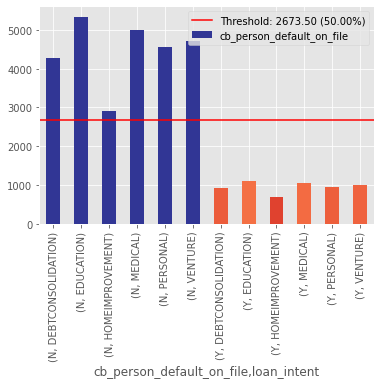

In [ ]:
import xai
im = xai.imbalance_plot(pdf, "cb_person_default_on_file", "loan_intent")

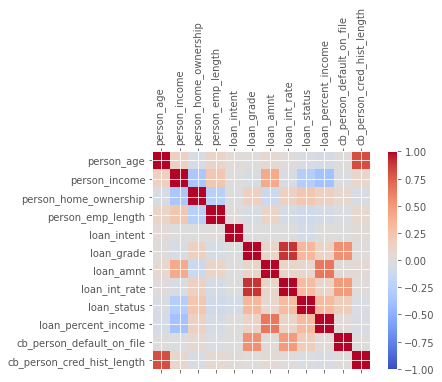

In [ ]:
correlated = xai.correlations(pdf, include_categorical=True, plot_type="matrix")